# Group 35 Project Report

## Introduction

Pulsars are rotating neutron stars. They produce radio emissions in a beam that can be detected when it sweeps past the Earth. However, not all such signals come from pulsars. Machine learning can be used in conjunction with radio emissions data to help distinguish pulsars based on these signals. For our project we will train a K-Nearest Neighbours model to predict whether or not radio emissions belong to a pulsar. We will do so using the HTRU2 dataset contributed to the University of Irvine Machine Learning Repository by Robert Lyon. This dataset contains 17 898 observations of radio emissions, 1 639 of which come from pulsars and 16 259 of which do not. 

## Methods and Results

In [1]:
# Load necessary libraries
library(tidyverse)
library(tidymodels)
install.packages("kknn",  repos='http://cran.us.r-project.org')
#library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

The data for this specific dataset is provided in both CSV and ARFF formats. We have opted to use the the provided CSV whose columns are unlabelled initially, but are described in the Readme.txt file. Thus, we add the column names ourselves in the call to read_csv. The column names are:

* Mean of the integrated profile.
* Standard deviation of the integrated profile.
* Excess kurtosis of the integrated profile.
* Skewness of the integrated profile.
* Mean of the DM-SNR curve.
* Standard deviation of the DM-SNR curve.
* Excess kurtosis of the DM-SNR curve.
* Skewness of the DM-SNR curve.
* Pulsar Classifier

For our preliminary analysis of our dataset we grouped the data by the pulsar classifier and compared the means of all the predictor variables.

In [2]:
# URL to where the data is stored on our group's github repository
data_url <-'https://raw.githubusercontent.com/aronthemon/dsci-100-group-project/main/data/HTRU_2.csv'

# Read data from the dataset's CSV file
# Add column names based on the documention in readme.txt
# Convert the pulsar binary classification to a factor so it can be used later.
pulsar_data <- read_csv(data_url, 
                        col_names= c(
                            "ip_mean", 
                            "ip_std_dev", 
                            "ip_excess_kurtosis", 
                            "ip_skewness", 
                            "dm_snr_mean", 
                            "dm_snr_std_dev", 
                            "dm_snr_excess_kurtosis", 
                            "dm_snr_skewness", 
                            "pulsar")) |>
                mutate(pulsar = as_factor(pulsar))

# Display the first 6 rows of our data
head(pulsar_data, 6)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): ip_mean, ip_std_dev, ip_excess_kurtosis, ip_skewness, dm_snr_mean, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ip_mean,ip_std_dev,ip_excess_kurtosis,ip_skewness,dm_snr_mean,dm_snr_std_dev,dm_snr_excess_kurtosis,dm_snr_skewness,pulsar
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [3]:
# We create a table with a summary of the classifiers in our data and 
# the means of the predictors grouped by their predictors
pulsar_summary <- group_by(pulsar_data, pulsar) |> 
                  summarize(
                      observations = n(), 
                      mean_of_ip_mean = mean(ip_mean),
                      mean_of_ip_std_dev = mean(ip_std_dev),
                      mean_of_ip_kurtosis = mean(ip_excess_kurtosis),
                      mean_of_ip_skewness = mean(ip_skewness),
                      mean_of_dm_snr_mean = mean(dm_snr_mean),
                      mean_of_dm_snr_std_dev = mean(dm_snr_std_dev),
                      mean_of_dm_snr_kurtosis = mean(dm_snr_excess_kurtosis),
                      mean_of_dm_snr_skewness = mean(dm_snr_skewness)
                  )

pulsar_summary

pulsar,observations,mean_of_ip_mean,mean_of_ip_std_dev,mean_of_ip_kurtosis,mean_of_ip_skewness,mean_of_dm_snr_mean,mean_of_dm_snr_std_dev,mean_of_dm_snr_kurtosis,mean_of_dm_snr_skewness
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,16259,116.56273,47.33974,0.2104401,0.380844,8.863258,23.28798,8.862674,113.62034
1,1639,56.69061,38.71060,3.1306554,15.553576,49.825995,56.46896,2.757069,17.93173


Next, we made histograms of our predictors in order to visualize the distributions of each column and to inspect the differences between the celestial bodies classified as pulsars, and those classified as non-pulsars.

Warning message:
“The `labeller` API has been updated. Labellers taking `variable` and `value`
arguments are now deprecated.
ℹ See labellers documentation.”
Warning message:
“The `labeller` API has been updated. Labellers taking `variable` and `value`
arguments are now deprecated.
ℹ See labellers documentation.”
Warning message:
“The `labeller` API has been updated. Labellers taking `variable` and `value`
arguments are now deprecated.
ℹ See labellers documentation.”
Warning message:
“The `labeller` API has been updated. Labellers taking `variable` and `value`
arguments are now deprecated.
ℹ See labellers documentation.”
Warning message:
“The `labeller` API has been updated. Labellers taking `variable` and `value`
arguments are now deprecated.
ℹ See labellers documentation.”
Warning message:
“The `labeller` API has been updated. Labellers taking `variable` and `value`
arguments are now deprecated.
ℹ See labellers documentation.”
Warning message:
“The `labeller` API has been updated. Lab

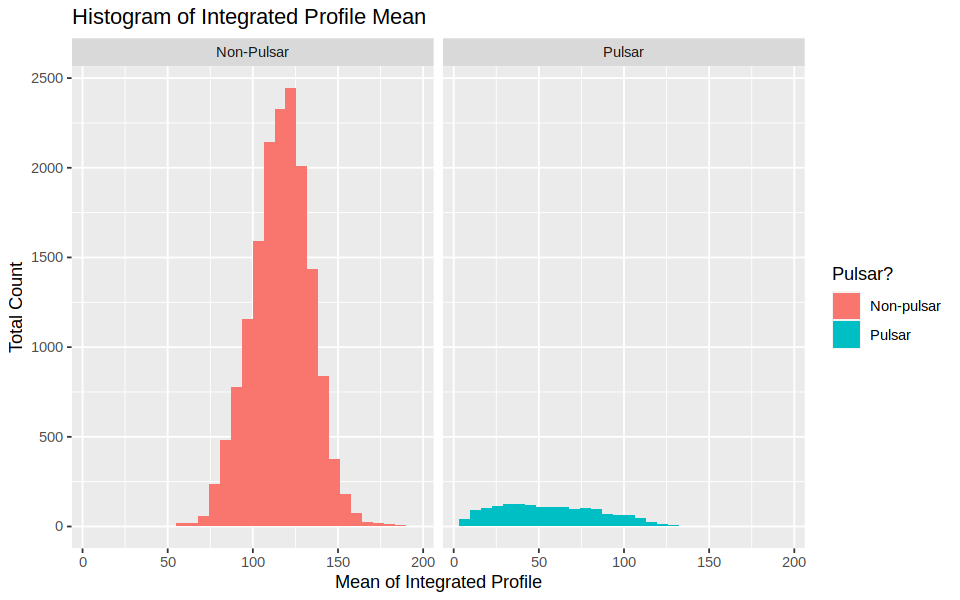

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


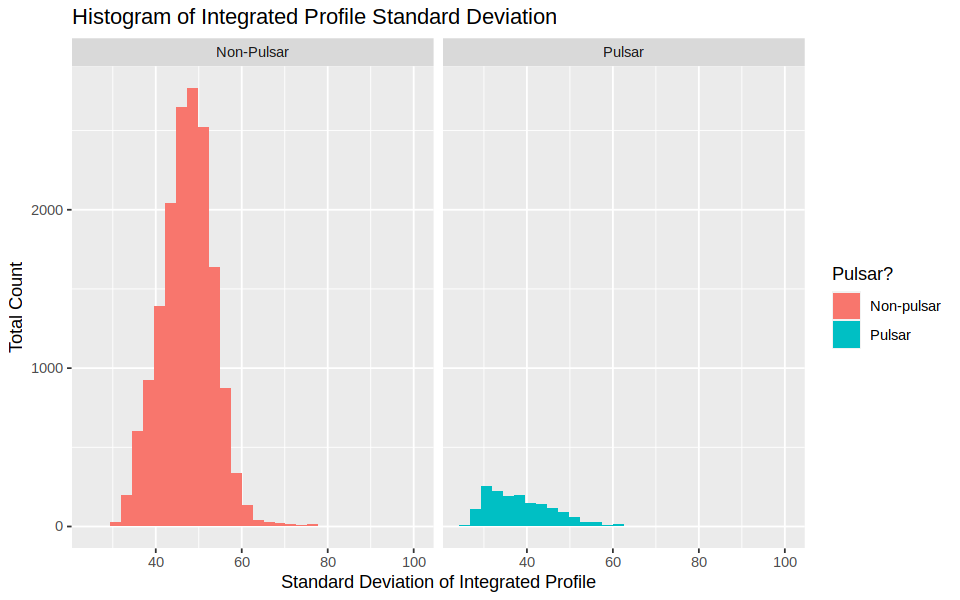

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


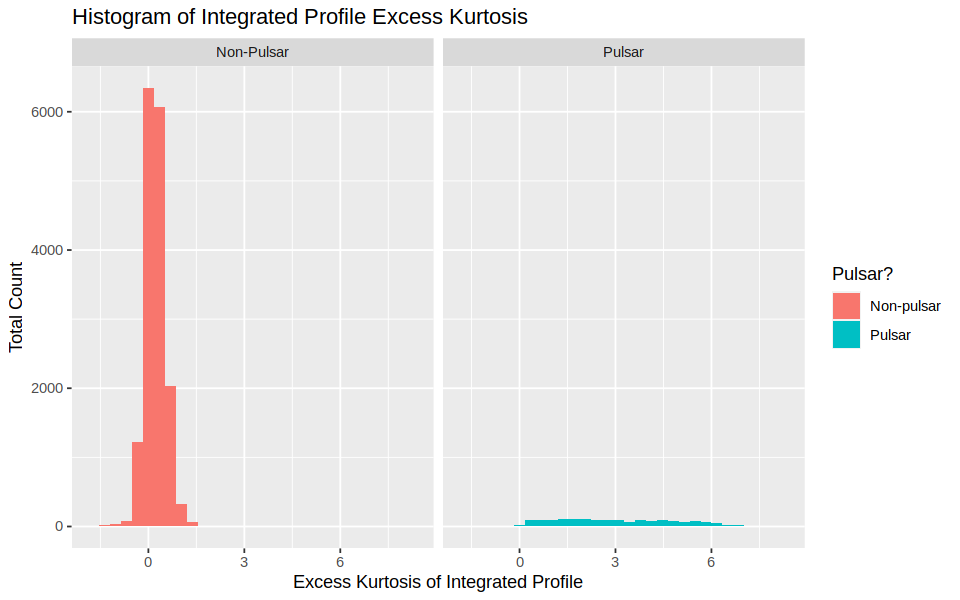

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


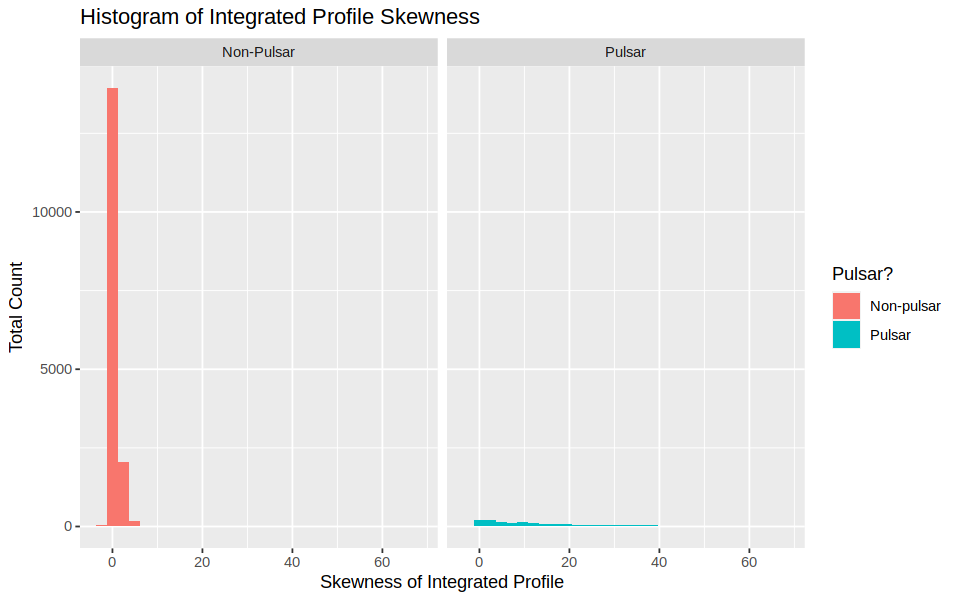

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


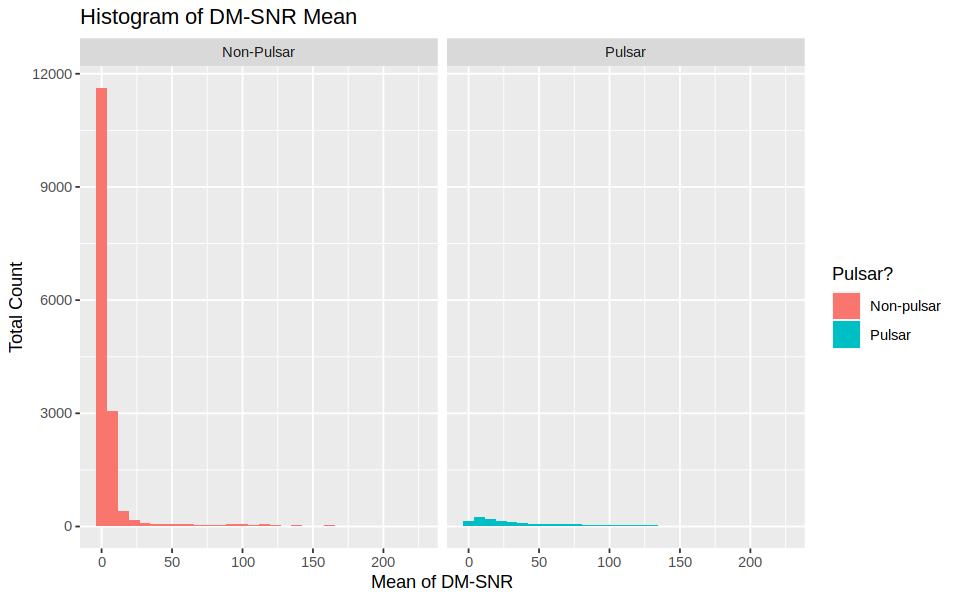

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


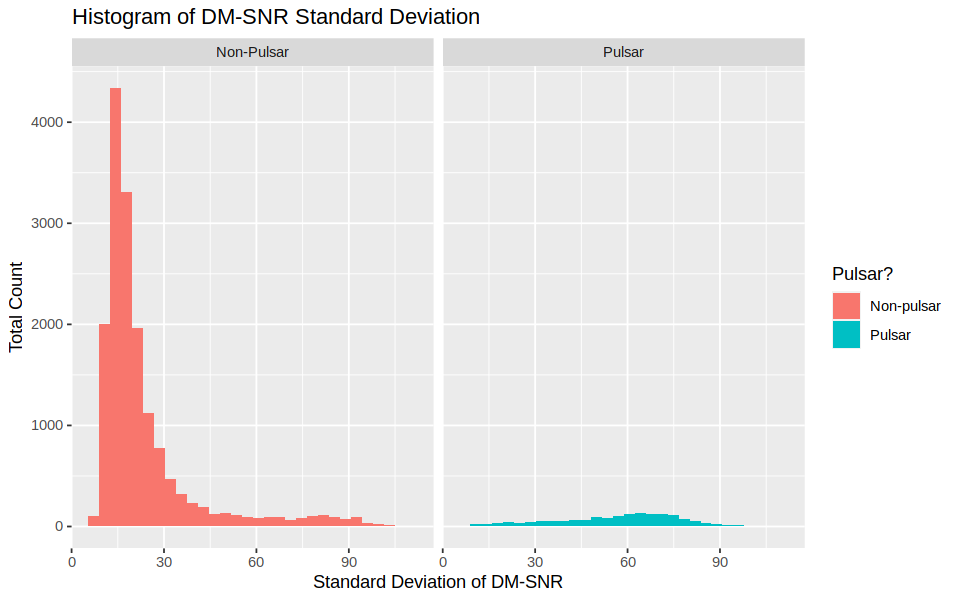

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


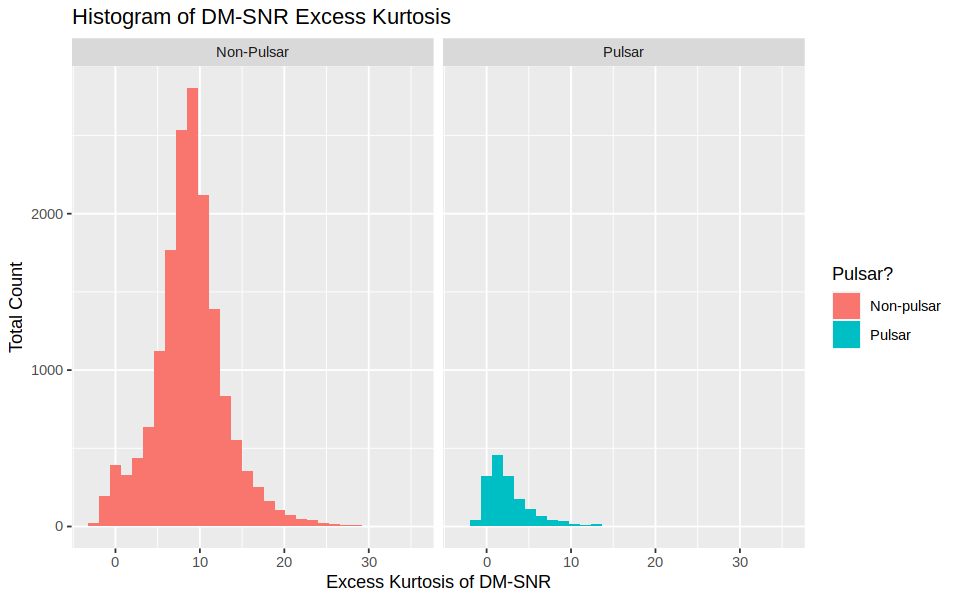

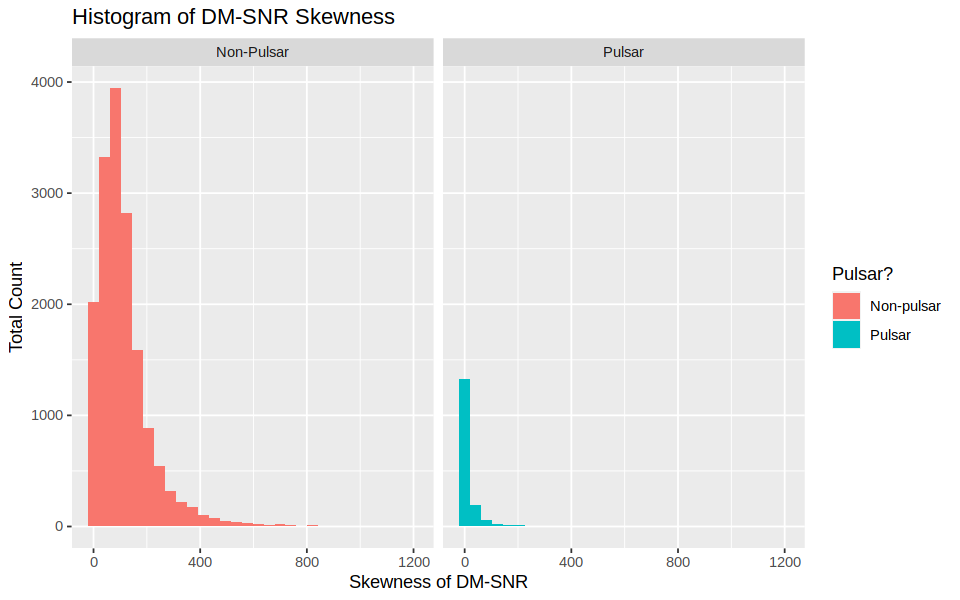

In [11]:
options(repr.plot.height = 5, repr.plot.width = 8)

# Labels for facet grid
label_list <- list(
                    "0" = "Non-Pulsar",
                    "1" = "Pulsar"
                  )
# labeller function to pass to the facet_grid function
pulsar_labeller <- function(variable,value){
  return(label_list[value])
}

# Assign the plot variables and give them appropriate labels
ip_mean_plot <- ggplot(pulsar_data, aes(x = ip_mean, fill=pulsar)) +
    geom_histogram() +
    xlab("Mean of Integrated Profile") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of Integrated Profile Mean")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)

ip_std_dev_plot <- ggplot(pulsar_data, aes(x = ip_std_dev, fill=pulsar)) +
    geom_histogram() +
    xlab("Standard Deviation of Integrated Profile") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of Integrated Profile Standard Deviation")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)

ip_excess_kurtosis <- ggplot(pulsar_data, aes(x = ip_excess_kurtosis, fill=pulsar)) +
    geom_histogram() +
    xlab("Excess Kurtosis of Integrated Profile") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of Integrated Profile Excess Kurtosis")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)

ip_skewness <- ggplot(pulsar_data, aes(x = ip_skewness, fill=pulsar)) +
    geom_histogram() +
    xlab("Skewness of Integrated Profile") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of Integrated Profile Skewness")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)

dm_snr_mean_plot <- ggplot(pulsar_data, aes(x = dm_snr_mean, fill=pulsar)) +
    geom_histogram() +
    xlab("Mean of DM-SNR") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of DM-SNR Mean")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)

dm_snr_std_dev_plot <- ggplot(pulsar_data, aes(x = dm_snr_std_dev, fill=pulsar)) +
    geom_histogram() +
    xlab("Standard Deviation of DM-SNR") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of DM-SNR Standard Deviation")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)

dm_snr_excess_kurtosis <- ggplot(pulsar_data, aes(x = dm_snr_excess_kurtosis, fill=pulsar)) +
    geom_histogram() +
    xlab("Excess Kurtosis of DM-SNR") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of DM-SNR Excess Kurtosis")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)

dm_snr_skewness <- ggplot(pulsar_data, aes(x = dm_snr_skewness, fill=pulsar)) +
    geom_histogram() +
    xlab("Skewness of DM-SNR") +
    ylab("Total Count") +
    labs(fill="Pulsar?") +
    scale_fill_discrete(breaks = c(0, 1),
                             labels = c("Non-pulsar", "Pulsar")) +
    ggtitle("Histogram of DM-SNR Skewness")+
    facet_wrap(vars(pulsar), labeller = pulsar_labeller)


# Display plots
ip_mean_plot
ip_std_dev_plot
ip_excess_kurtosis
ip_skewness
dm_snr_mean_plot
dm_snr_std_dev_plot
dm_snr_excess_kurtosis
dm_snr_skewness

Using these visualizations, we can see that for the Integrated Profile Mean, Integrated Profile Excess Kurtosis, and DM-SNR Standard Deviation variables, the histograms of non-pulsar and pulsar are different from each other, suggesting that they would be good predictors since their distributions are different. For the rest of the variables, both of their histograms have similar distributions, and would not be good predictor variables for predicting the classification of a pulsar.

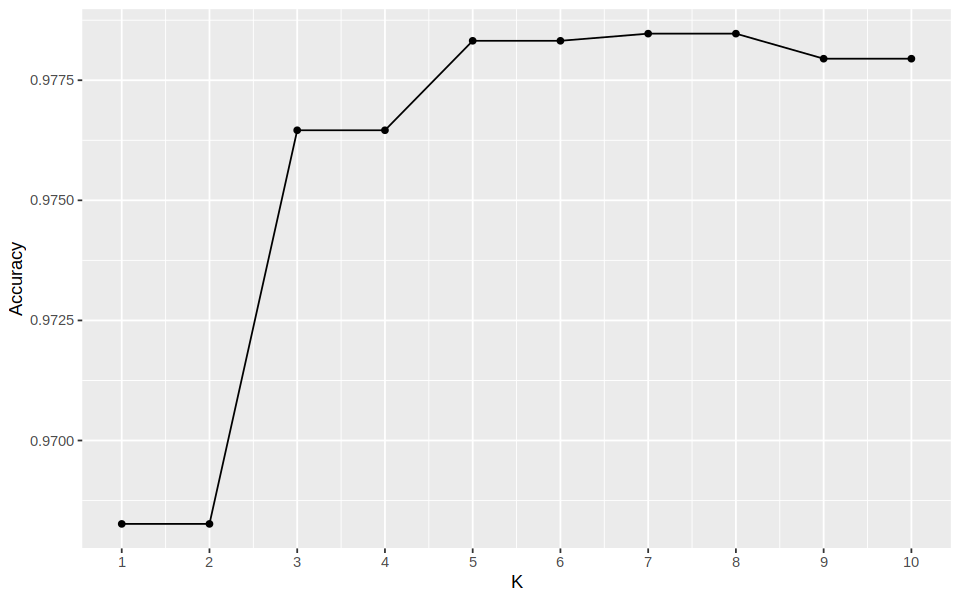

In [12]:
set.seed(2023) # DO NOT REMOVE

# Splitting the data set into 75% training and 25% testing set
pulsar_split <- initial_split(data = pulsar_data, prop = 0.75, strata = pulsar)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

# Making an object with K values from 1 to 10
k_vals <- tibble(neighbors = 1:10)

# Making a cross-validation object with 5 folds
k_vfold <- vfold_cv(data = pulsar_training, v = 5, strata = pulsar)

# Making the recipe and scaling all predictors
knn_recipe <- recipe(pulsar ~ ip_mean + ip_excess_kurtosis + dm_snr_std_dev, data = pulsar_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Making the specification (with tuning)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Getting the results of the tuned model
knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics()

# Getting the accuracies of the model
knn_accuracies <- knn_results |>
    filter(.metric == "accuracy")

# Plotting accuracy vs. K
accuracy_plot <- knn_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = 1:10) +
    xlab("K") +
    ylab("Accuracy")
accuracy_plot

As we can see from the K vs. accuracy plot of the training data set, the accuracy is the highest, at 0.9784701 with K = 8 and K = 7. So, let us choose K to be 7 for our model. Now, let us see how well the model with K = 7 will perform on the testing set.

In [13]:
set.seed(2023) # DO NOT REMOVE

# Making the model specification with K = 7
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

# Training the model to the training set
pulsar_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(best_k_spec) |>
    fit(pulsar_training)

# Predicting the classification of the test set
pulsar_predictions <- predict(pulsar_fit, pulsar_testing) |>
    bind_cols(pulsar_testing)

# Getting the accuracy of the model on the test set
pulsar_results <- pulsar_predictions |>
    metrics(truth = pulsar, estimate = .pred_class) |>
    filter(.metric == "accuracy")
pulsar_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9803352


Now, we know that the accuracy of our model on the testing set is 0.9803352, which is really good!

## Discussion

## References